In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def p2f(x):
    if isinstance(x, str): 
        return float(x.strip('%'))/100
    return x


def GRLC(values):
    '''
    Calculate Gini index, Gini coefficient, Robin Hood index, and points of 
    Lorenz curve based on the instructions given in 
    www.peterrosenmai.com/lorenz-curve-graphing-tool-and-gini-coefficient-calculator
    Lorenz curve values as given as lists of x & y points [[x1, x2], [y1, y2]]
    @param values: List of values
    @return: [Gini index, Gini coefficient, Robin Hood index, [Lorenz curve]] 
    '''
    n = len(values)
    assert(n > 0), 'Empty list of values'
    sortedValues = sorted(values) #Sort smallest to largest

    #Find cumulative totals
    cumm = [0]
    for i in range(n):
        cumm.append(sum(sortedValues[0:(i + 1)]))

    #Calculate Lorenz points
    LorenzPoints = [[], []]
    sumYs = 0           #Some of all y values
    robinHoodIdx = -1   #Robin Hood index max(x_i, y_i)
    for i in range(1, n + 2):
        x = 100.0 * (i - 1)/n
        y = 100.0 * (cumm[i - 1]/float(cumm[n]))
        LorenzPoints[0].append(x)
        LorenzPoints[1].append(y)
        sumYs += y
        maxX_Y = x - y
        if maxX_Y > robinHoodIdx: robinHoodIdx = maxX_Y   
    
    giniIdx = 100 + (100 - 2 * sumYs)/n #Gini index 

    return [giniIdx, giniIdx/100, robinHoodIdx, LorenzPoints]



In [3]:
# Load in our CMS dataset
df = pd.read_csv('cms_2015.csv', index_col=['State and County FIPS Code', 'State', 'County'])

In [4]:
# Replace supressed values with NaN
df.replace('*', np.nan, inplace=True)

# Get rid of '%' char. Turn all columns into numeric
for col in df:
    if 'percent' in col.lower() or '%' in col:
        df[col] = df[col].map(p2f)
    df[col]=pd.to_numeric(df[col],'coerce')

# Drop all of the totals into a different df
df['County']=df.index.get_level_values('County')
mask = df['County'].str.contains('TOTAL', na=False)
totals = df[mask]
df = df[~mask]

# Distribution of Cost by Population 
By calculating a Gini coefficient for each column, we are able to visually display the distribution of Medicare costs across all represented counties, a quick method to identify variations. The y-value at any given point of the blue curve indicates the cumulative cost produced by that percentile of the population. The orange dashed line is a thereotical line of equality where all costs are evenly distributed among the population. 

Let's take a look at standardized per capita costs below. This graph has a Gini value of .09, which is quite good! For reference, when income inequality is evaluated, the lowest value was .24 (Slovenia) and the highest .49 (Chile). This result shouldn't be too suprising. As a whole, CMS should be disbursing funds equitablly. 



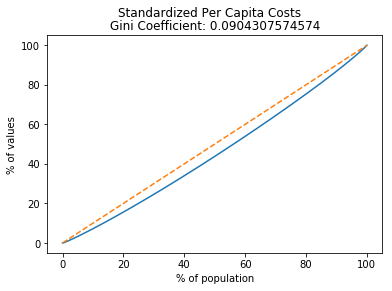

In [5]:
result = GRLC(df['Standardized Per Capita Costs'].fillna(0.00001).as_matrix())
plt.plot(result[3][0], result[3][1], [0, 100], [0, 100], '--')
plt.xlabel('% of population')
plt.ylabel('% of values')
plt.suptitle('Standardized Per Capita Costs')
plt.title('Gini Coefficient: ' + str(result[1]))
plt.show()

### Home Health and Skilled Nursing Facilities
To find some examples of greater inequality, let's take a look at Skilled Nursing Facilities and Home Health costs, two services that are relatively substitutable.

In the first graph (SNF Actual Costs), we can see that roughly 20% of SNF costs are attributed to 80% of all counties! This tells us that SNF usage and costs are heavily concentrated in a relatively small population of our data set. We can then target the subset of data that relies on SNF and HH for further analysis. 


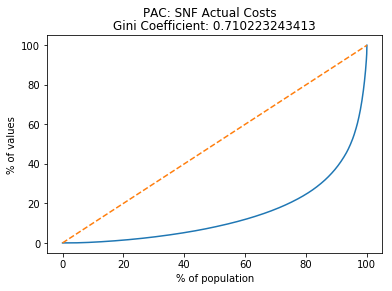

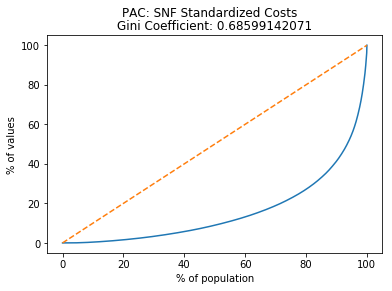

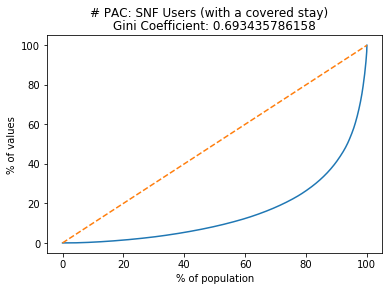

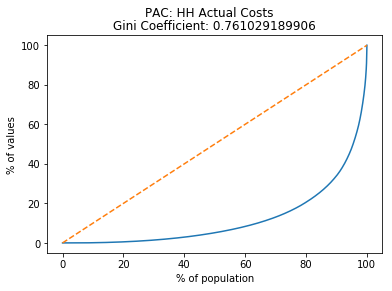

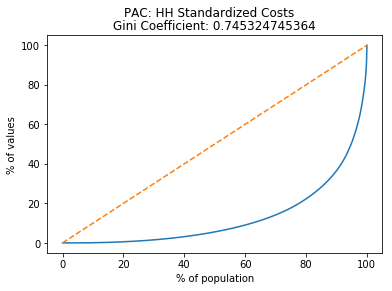

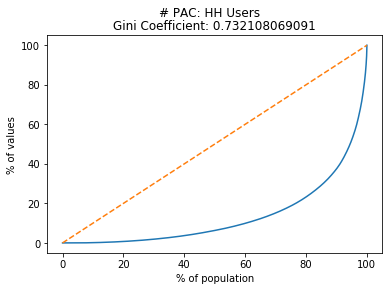

In [6]:
cols = [c for c in df.columns if 'HH' in c or 'SNF' in c]
df1 = df[cols]

for c in df1:   
    result = GRLC(df[c].fillna(0.00001).as_matrix())
    if result[1] > .5:
        plt.plot(result[3][0], result[3][1], [0, 100], [0, 100], '--')
        plt.xlabel('% of population')
        plt.ylabel('% of values')
        plt.suptitle(c)
        plt.title('Gini Coefficient: ' + str(result[1]))
        plt.show()

## Per Capita Costs
However, that's not really a fair analysis. All we've really pointed out is that more populous counties will have more users and higher costs. So let's restrict our columns to per capita costs and take a look at all services where the Gini coefficient rises above .5, what many would consider to be a very unequal distribution of resources. 

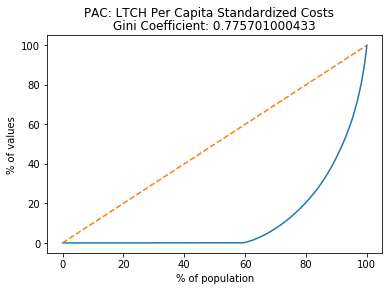

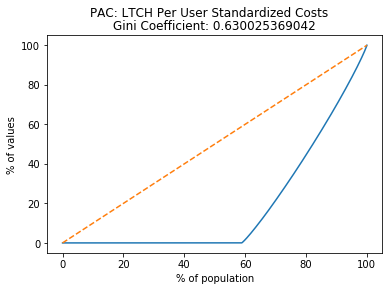

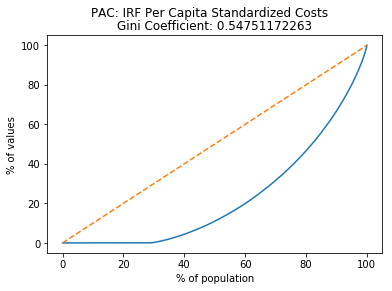

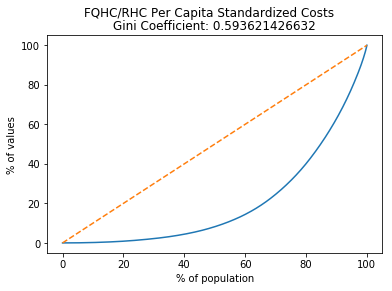

In [22]:
cols = [c for c in df.columns if ('Per Capita' in c or 'Per User' in c) and 'Standardized' in c]
for c in df[cols]: 
    result = GRLC(df[c].fillna(0.00001).as_matrix())
    if result[1] > .5:
        plt.plot(result[3][0], result[3][1], [0, 100], [0, 100], '--')
        plt.xlabel('% of population')
        plt.ylabel('% of values')
        plt.suptitle(c)
        plt.title('Gini Coefficient: ' + str(result[1]))
        plt.show()

The new Lorenz curves show us that Long Term Care Hospitals (LTCH), Inpatient Rehab Facilities (IRF) and Federally Qualified Health Centers/Rural Health Clinics (FQHC/RHC) are the services with unequal per capita cost distributions. 

The flat line at the beginning of many of these graphs also indicates that many counties are not users of these services. Only ~40% of counties utilize LTCH and ~20% for IRF. This will definitely drive a Gini value up, so let's remove all counties that do not utilize these services and see how cost is distributed.

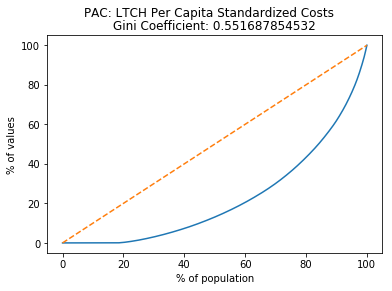

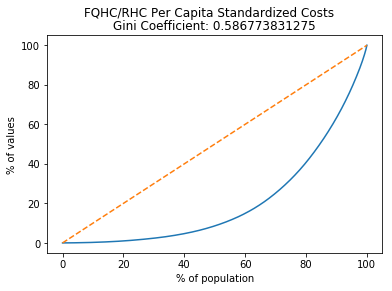

In [28]:
for c in df[cols]: 
    result = GRLC(df[c].dropna().as_matrix())
    if result[1] > .5:
        plt.plot(result[3][0], result[3][1], [0, 100], [0, 100], '--')
        plt.xlabel('% of population')
        plt.ylabel('% of values')
        plt.suptitle(c)
        plt.title('Gini Coefficient: ' + str(result[1]))
        plt.show()

Now that we're accounting for usage and access, IRF has dropped out. Let's slice out LTCH and FQHC/RHC and view the distribution of cost on a choropleth in Tableau: 

In [29]:
df[['FQHC/RHC Per Capita Standardized Costs','FQHC/RHC Per User Standardized Costs','PAC: LTCH Per Capita Standardized Costs' ,'PAC: LTCH Per User Standardized Costs','# FQHC/RHC Users', '# PAC: LTCH Users (with a covered stay)']].to_csv('choropleth.csv')

In [20]:
%%HTML 
<div class='tableauPlaceholder' id='viz1502482386603' style='position: relative'><noscript><a href='#'><img alt='FQHC and LTCH ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ro&#47;RowdMap-FQHCandLTCH&#47;Story1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='RowdMap-FQHCandLTCH&#47;Story1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ro&#47;RowdMap-FQHCandLTCH&#47;Story1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1502482386603');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Bonus: Demand Elasticity SNF and HH 

To evaluate the relationship between SNF and HH cost on usage, a simple scatter plot indicates a relatively inelastic demand. The medical necessity of these services may explain this finding. 

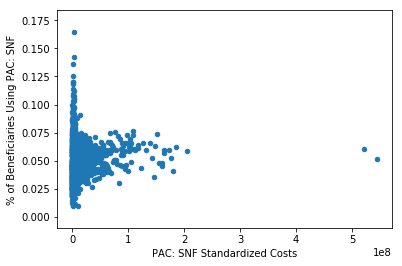

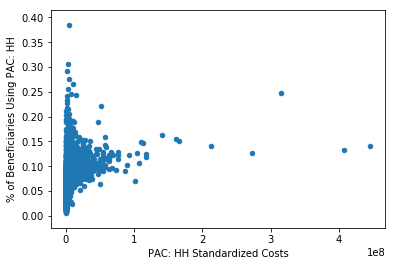

In [9]:
from pandas import scatter_matrix

df1.loc[df['PAC: SNF Standardized Costs'] > 0].plot.scatter(x='PAC: SNF Standardized Costs', y='% of Beneficiaries Using PAC: SNF')
plt.show()

df1.loc[df['PAC: HH Standardized Costs'] > 0].plot.scatter(x='PAC: HH Standardized Costs', y='% of Beneficiaries Using PAC: HH')
plt.show()



### Bonus: Quick Correlation Hunt

Pandas allows users to quickly evaluate linear relationships between data columns. I have organized the top correlations below, but most relationships are endogenous. 

In [10]:
corr_matrix = df.corr().abs()
os = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .order(ascending=False))
os


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


Percent Female                                          Percent Male                                                                        1.000000
Part B Drugs Actual Costs                               Part B Drugs Standardized Costs                                                     0.999997
Part B Drugs Per User Actual Costs                      Part B Drugs Per User Standardized Costs                                            0.999982
Part B Drugs Per Capita Actual Costs                    Part B Drugs Per Capita Standardized Costs                                          0.999981
Tests Actual Costs                                      Tests Standardized Costs                                                            0.999626
Outpatient Dialysis Facility Standardized Costs         # Outpatient Dialysis Facility Users                                                0.999579
# E&M Users                                             # Imaging Users                                   